In [1]:
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr

from rpy2.robjects import numpy2ri
from rpy2.robjects import pandas2ri
from rpy2.robjects import r
from rpy2 import robjects as ro

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

## Activate numpy and pandas for R

In [2]:
numpy2ri.activate()
pandas2ri.activate()

## Import R libraries and functions

In [4]:
#utils = importr('utils')
#utils.chooseCRANmirror(ind=1)
#utils.install_packages('gamlss')

lib_loc = os.path.join(os.environ['R_HOME'], 'library')
base = importr('base')
gamlss_data = importr('gamlss.data', lib_loc=lib_loc)
gamlss_dist = importr('gamlss.dist', lib_loc=lib_loc)
gamlss = importr('gamlss', lib_loc=lib_loc)

/usr/local/Caskroom/miniforge/base/lib/python3.9/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '


In [4]:
as_factor = r['as.factor']

In [5]:
NO = r['NO']
SHASHo2 = r['SHASHo2']
formula = r['formula']
predict = r['predict']
cs = r['cs']
ps = r['ps']
predict_gamlss = gamlss.predict_gamlss

## Define functions to generate data

In [6]:
def model(age, sex, offset):
    noise = np.random.normal(0, 0.1)
    return 0.001*age-0.00001*(age-50)**2+0.5 + noise - np.random.uniform(0, 0.3) * sex + offset


def model_prob(age, sex, offset):
    noise = np.random.normal(0, 0.1)
    return 0.001*age-0.00001*(age-50)**2+0.5 + noise - np.random.uniform(0, 0.3) * sex - 0.2 * np.random.uniform() + offset

def generate_data(group='PROB_CON', sample_size=1, n_sites=2, randseed=3):
    np.random.seed(randseed)
    n_sites = n_sites
    age_min = (np.random.rand(n_sites)*50).astype(int)
    sites = pd.DataFrame(data={'sex_ratio': np.random.rand(n_sites),
                               'prob_ratio': 0.5*np.random.rand(n_sites),
                               'age_min': age_min,
                               'age_max': (age_min+5+np.random.rand(n_sites)*50).astype(int),
                               'score_shift': np.random.randn(n_sites)/4,
                               'sample_size': (sample_size+np.random.rand(n_sites)*sample_size*10).astype(int)})

    participants = []
    for site in sites.iterrows():
        for participant in range(int(site[1]['sample_size'])):
            sex = np.random.binomial(1, site[1]['sex_ratio'])
            prob = np.random.binomial(1, site[1]['prob_ratio'])
            age = np.random.uniform(site[1]['age_min'], site[1]['age_max'])
            if prob:
                score = model_prob(age, sex, site[1]['score_shift'])
            else:
                score = model(age, sex, site[1]['score_shift'])
            participants.append([site[0], sex, prob, age, score])

    df = pd.DataFrame(participants, columns=['site', 'sex', 'group', 'age', 'score'])
    df.sex.replace({1: 'Female', 0: 'Male'}, inplace=True)
    if group == 'PROB_CON':
        df.group.replace({1: 'PROB', 0: 'CTR'}, inplace=True)
    return df

## Generate data

In [7]:
df = generate_data(n_sites=4,sample_size=35,randseed=650)
print('n subjects = {}'.format(df.shape[0]))

n subjects = 872


In [51]:
df.head()

,site,sex,group,age,score
0,0,Female,CTR,43.815051,0.853690
1,0,Female,CTR,53.602897,0.486257
2,0,Female,CTR,60.121669,0.518633
3,0,Female,CTR,44.804455,0.767740
4,0,Female,CTR,48.738191,0.508351


In [39]:
ro.globalenv['site_r'] = ro.vectors.FactorVector(df['site'].to_numpy())
ro.globalenv['sex_r'] = ro.StrVector(df['sex'].to_numpy())
ro.globalenv['group_r'] = ro.StrVector(df['group'].to_numpy())
ro.globalenv['age_r'] = ro.FloatVector(df['age'].to_numpy())
ro.globalenv['score_r'] = ro.FloatVector(df['score'].to_numpy())

df_r = r("data.frame('site'=site_r,'sex'=sex_r,'group'=group_r,'age'=age_r,'score'=score_r)")
ro.globalenv['df_r'] = df_r
print(r("is.factor(df_r$site)"))
df_r

array([1], dtype=int32)

## Visualize data

Text(0.5, 1.0, 'By sex')

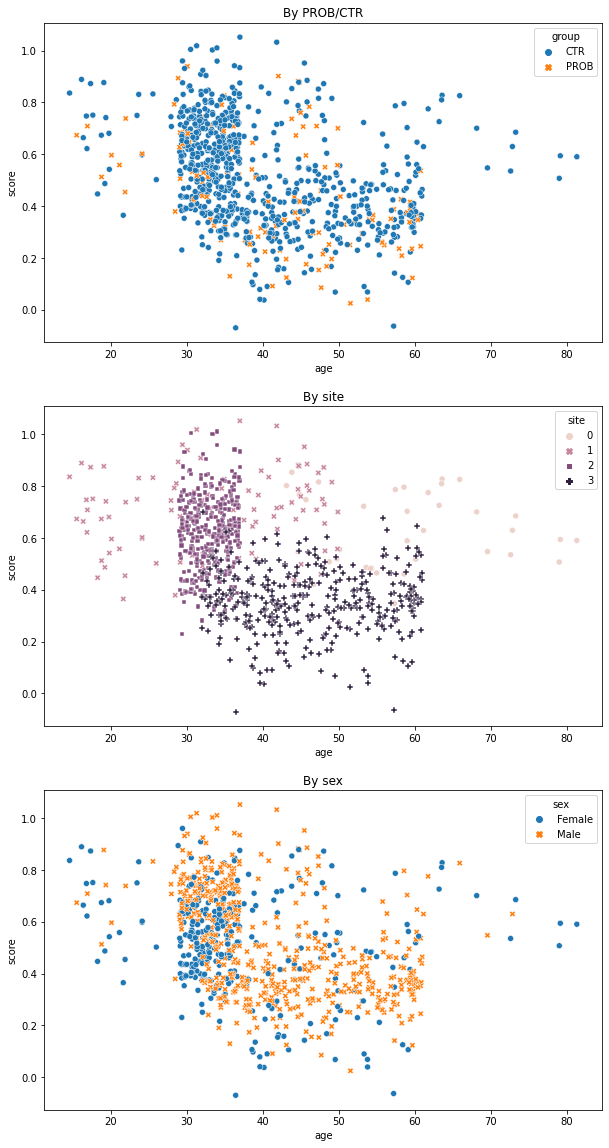

In [12]:
fig,ax = plt.subplots(3,1,figsize=(10,20))

sns.scatterplot(data=df, x='age', y='score', hue='group', style='group',ax=ax[0])
sns.scatterplot(data=df, x='age', y='score', hue='site', style='site',ax=ax[1])
sns.scatterplot(data=df, x='age', y='score', hue='sex', style='sex',ax=ax[2])

ax[0].set_title('By PROB/CTR')
ax[1].set_title('By site')
ax[2].set_title('By sex')

In [8]:
df.head()

,site,sex,group,age,score
0,0,Female,CTR,65.818713,0.409020
1,0,Female,CTR,68.827045,0.294608
2,0,Male,CTR,61.660016,0.313654
3,0,Male,CTR,66.886592,0.423175
4,0,Male,CTR,55.738248,0.257225


In [30]:
#base.warnings()

Algorithm RS has not yet converged,[RTYPES.LANGSXP]


In [25]:
r("vec1 <- c('yes','yes','no')")
r("vec2 <- c(1,2,3)")
r("vec3 <- c('A','B','C')")
r("data <- data.frame(vec1,vec2,vec3)")
r("is.factor(data$vec1)")
r("is.factor(df$sex)")

R[write to console]: Error in df$sex : object of type 'closure' is not subsettable
Calls: <Anonymous> -> <Anonymous> -> is.factor



RRuntimeError: Error in df$sex : object of type 'closure' is not subsettable
Calls: <Anonymous> -> <Anonymous> -> is.factor


## Fit GAMLSS

In [63]:
f1 = formula('score ~ age + c(sex) + random(as.factor(site))')
g1 = gamlss.gamlss(f1,
                    sigma_formula = formula('~ 1'),
                    nu_formula = formula('~ 1'),
                    tau_formula = formula('~ 1'),
                    data=df_r,
                    family=SHASHo2)

GAMLSS-RS iteration 1: Global Deviance = -1000.73 
GAMLSS-RS iteration 2: Global Deviance = -1143.708 
GAMLSS-RS iteration 3: Global Deviance = -1190.14 
GAMLSS-RS iteration 4: Global Deviance = -1207.353 
GAMLSS-RS iteration 5: Global Deviance = -1214.191 
GAMLSS-RS iteration 6: Global Deviance = -1217.083 
GAMLSS-RS iteration 7: Global Deviance = -1218.388 
GAMLSS-RS iteration 8: Global Deviance = -1219.016 
GAMLSS-RS iteration 9: Global Deviance = -1219.337 
GAMLSS-RS iteration 10: Global Deviance = -1219.509 
GAMLSS-RS iteration 11: Global Deviance = -1219.609 
GAMLSS-RS iteration 12: Global Deviance = -1219.668 
GAMLSS-RS iteration 13: Global Deviance = -1219.705 
GAMLSS-RS iteration 14: Global Deviance = -1219.729 
GAMLSS-RS iteration 15: Global Deviance = -1219.744 
GAMLSS-RS iteration 16: Global Deviance = -1219.754 
GAMLSS-RS iteration 17: Global Deviance = -1219.762 
GAMLSS-RS iteration 18: Global Deviance = -1219.767 
GAMLSS-RS iteration 19: Global Deviance = -1219.771 
GAML

## Predict from GAMLSS

In [64]:
df2 = generate_data(n_sites=5,sample_size=35,randseed=651)
predict_gamlss(g1,newdata=df_r,what='sigma')

array([-2.1425373, -2.1425373, -2.1425373, -2.1425373, -2.1425373,
       -2.1425373, -2.1425373, -2.1425373, -2.1425373, -2.1425373,
       -2.1425373, -2.1425373, -2.1425373, -2.1425373, -2.1425373,
       -2.1425373, -2.1425373, -2.1425373, -2.1425373, -2.1425373,
       -2.1425373, -2.1425373, -2.1425373, -2.1425373, -2.1425373,
       -2.1425373, -2.1425373, -2.1425373, -2.1425373, -2.1425373,
       -2.1425373, -2.1425373, -2.1425373, -2.1425373, -2.1425373,
       -2.1425373, -2.1425373, -2.1425373, -2.1425373, -2.1425373,
       -2.1425373, -2.1425373, -2.1425373, -2.1425373, -2.1425373,
       -2.1425373, -2.1425373, -2.1425373, -2.1425373, -2.1425373,
       -2.1425373, -2.1425373, -2.1425373, -2.1425373, -2.1425373,
       -2.1425373, -2.1425373, -2.1425373, -2.1425373, -2.1425373,
       -2.1425373, -2.1425373, -2.1425373, -2.1425373, -2.1425373,
       -2.1425373, -2.1425373, -2.1425373, -2.1425373, -2.1425373,
       -2.1425373, -2.1425373, -2.1425373, -2.1425373, -2.1425

In [16]:
centiles = r['centiles']
centiles.pred(g)

% of cases below  0.4 centile is  0.2277904 
% of cases below  2 centile is  2.050114 
% of cases below  10 centile is  10.82005 
% of cases below  25 centile is  24.82916 
% of cases below  50 centile is  48.86105 
% of cases below  75 centile is  75.28474 
% of cases below  90 centile is  90.88838 
% of cases below  98 centile is  97.6082 
% of cases below  99.6 centile is  99.20273 


<rpy2.rinterface.NULLType object at 0x7f9ed0057640> [RTYPES.NILSXP]

In [63]:
predict = r['predict']
predict(g2,what='sigma',type='response')[1]

0.5863109588633391

In [19]:
fakef = 'var1 ~ f(var2*var3) + beeopooo'

In [21]:
fakef.split('~')[1]

' f(var2*var3) + beeopooo'

In [70]:
resid = r['residuals']
resid(g3)

array([-2.38704391e+00, -1.20444985e-01,  2.77362893e-01,  9.19865731e-02,
        9.76881368e-01,  8.63147812e-01,  8.40354693e-01,  9.86139611e-01,
        6.80144323e-01, -1.80452297e+00,  2.28242809e-02,  1.41148279e+00,
        1.41712566e-01, -4.03387622e-01,  1.53023265e+00,  1.57820853e+00,
        1.02675578e+00, -5.04893617e-01,  6.69146432e-01,  9.38183780e-01,
       -8.47353408e-01, -6.80962776e-01, -1.28056403e+00,  7.15260800e-01,
       -3.90037914e-01, -1.65556282e-01, -1.98164458e+00,  1.38765401e-01,
       -4.44314111e-01, -6.96634388e-01, -6.00754726e-01,  2.38821198e+00,
       -1.03212532e+00,  3.17188011e-01, -2.79026821e-01,  5.34448467e-01,
       -1.58012341e+00,  6.69511463e-01, -2.13453005e-01,  1.99097848e+00,
       -2.95223910e-01, -3.36964886e-01, -6.83964516e-01,  8.89793270e-01,
       -1.02000863e+00, -5.76303299e-01,  1.72770831e+00,  7.17115406e-01,
        2.01490699e-01,  4.28974527e-01,  2.11455285e+00, -4.27558079e-01,
       -3.28042101e-01, -

In [74]:
plot = r['plot']
plot(g3)

******************************************************************
	      Summary of the Quantile Residuals
                           mean   =  -0.003772006 
                       variance   =  1.000987 
               coef. of skewness  =  0.01337103 
               coef. of kurtosis  =  2.977382 
Filliben correlation coefficient  =  0.9993427 
******************************************************************


mfrow,[RTYPES.INTSXP]
mar,[RTYPES.REALSXP]
col.axis,[RTYPES.STRSXP]
col.main,[RTYPES.STRSXP]
col.lab,[RTYPES.STRSXP]
col,[RTYPES.STRSXP]
bg,[RTYPES.STRSXP]


In [9]:
SHASHo2 = r['SHASHo2']
g4 = gamlss.gamlss(formula('score~lo(~x,span=.4)'),
                    sigma_formula=formula('~lo(~x,span=.4)'),
                    data=df,
                    family=SHASHo2)

GAMLSS-RS iteration 1: Global Deviance = 1896.31 
GAMLSS-RS iteration 2: Global Deviance = 1699.117 
GAMLSS-RS iteration 3: Global Deviance = 1641.989 
GAMLSS-RS iteration 4: Global Deviance = 1620.39 
GAMLSS-RS iteration 5: Global Deviance = 1610.704 
GAMLSS-RS iteration 6: Global Deviance = 1606.056 
GAMLSS-RS iteration 7: Global Deviance = 1603.426 
GAMLSS-RS iteration 8: Global Deviance = 1601.943 
GAMLSS-RS iteration 9: Global Deviance = 1601.043 
GAMLSS-RS iteration 10: Global Deviance = 1600.468 
GAMLSS-RS iteration 11: Global Deviance = 1600.083 
GAMLSS-RS iteration 12: Global Deviance = 1599.868 
GAMLSS-RS iteration 13: Global Deviance = 1599.673 
GAMLSS-RS iteration 14: Global Deviance = 1599.506 
GAMLSS-RS iteration 15: Global Deviance = 1599.395 
GAMLSS-RS iteration 16: Global Deviance = 1599.313 
GAMLSS-RS iteration 17: Global Deviance = 1599.253 
GAMLSS-RS iteration 18: Global Deviance = 1599.209 
GAMLSS-RS iteration 19: Global Deviance = 1599.174 
GAMLSS-RS iteration 20:

In [81]:
AIC = r['AIC']
AIC(g2,g3,g4,k=3)

,df,AIC


In [10]:
r('''
 matcal <- function(mat) {
 s = sum(mat)
 sigma = sd(mat)
 return(c(s,sigma))
 }
''')
## This function can now be accessed with the __getitem__ mechanins
r_matcal = robjects.globalenv['matcal']
print(r_matcal.r_repr())

function (mat) 
{
    s = sum(mat)
    sigma = sd(mat)
    return(c(s, sigma))
}


In [17]:
A = np.random.randn(3,3)
r_matcal(A)

-3.113474,1.006387


In [ ]:
summary = r['summary']
summary(g)